In [1]:
import pandas as pd
import numpy as np
import utilities
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

## Read in data

In [2]:
stages = pd.read_csv('Edge520Stages.csv')
vector = pd.read_csv('Edge800Vector.csv')

## Rename columns to get rid of the UTF nonsense

In [3]:
## Rename columns Stages
stages.rename(columns={'\ufeffType':'Type'}, inplace=True)
## Rename columns Vector
vector.rename(columns={'\ufeffType':'Type'}, inplace=True)

## Headers: verify synchronization based on laps and start_time
### It is expected that the difference in laps time must be +/- sec comparable with difference in start time

In [4]:
## Type==Data, Message not record and not unknown
stages_header = stages[(stages['Type']=='Data') & (stages['Message']!='record') & (stages['Message']!='unknown')]
vector_header = vector[(vector['Type']=='Data') & (vector['Message']!='record') & (vector['Message']!='unknown')]

In [5]:
## Extract lap times
stages_laps = pd.to_datetime(stages_header[(stages_header['Message']=='lap')].dropna(axis=1)['Value 2']*1e9)
vector_laps = pd.to_datetime(vector_header[(vector_header['Message']=='lap')].dropna(axis=1)['Value 2']*1e9)
## Calculate delta for each lap trigger to verify synchronization - compare with start_time delta (see below)
stages_laps.reset_index(drop=True) - vector_laps.reset_index(drop=True)

0   268 days 07:13:52
1   268 days 07:13:54
2   268 days 07:13:53
3   268 days 07:13:52
4   268 days 07:13:53
5   268 days 07:13:53
6   268 days 07:13:52
7   268 days 07:13:52
8   268 days 07:13:53
9   268 days 07:13:53
Name: Value 2, dtype: timedelta64[ns]

In [6]:
## Extract start time
stages_start_time = pd.to_datetime(stages_header[(stages_header['Message']=='session')]
                                   .dropna(axis=1)['Value 2'].values[0]*1e9)
vector_start_time = pd.to_datetime(vector_header[(vector_header['Message']=='session')]
                                   .dropna(axis=1)['Value 2'].values[0]*1e9)
## start time delta
stages_start_time - vector_start_time

Timedelta('268 days 07:13:52')

## Records: extract useful records into a dataframe and convert timestamps to DateTime

In [7]:
## select only Type==Data with Meassage==record and drop columns that contain only nan
stages_records = stages[(stages['Type']=='Data') & (stages['Message']=='record')].copy().dropna(axis=1)
vector_records = vector[(vector['Type']=='Data') & (vector['Message']=='record')].copy().dropna(axis=1)

## Leave only useful columns and give them appropriate names
## Rename columns Stages
stages_records.rename(columns={'Value 1':'Timestamp',
                               'Value 5':'Power',
                               'Value 8':'Cadence'}, inplace=True)
## Rename columns Vector
vector_records.rename(columns={'Value 1':'Timestamp',
                               'Value 3':'Power',
                               'Value 4':'Cadence',
                               'Value 6':'Balance'}, inplace=True)
## Extract only useful columns
columns_to_keep_stages = ['Timestamp', 'Power', 'Cadence']
columns_to_keep_vector = ['Timestamp', 'Power', 'Cadence', 'Balance']
stages_records = stages_records[columns_to_keep_stages]
vector_records = vector_records[columns_to_keep_vector]
## Convert all data to int - because that is what Garmin outputs anyway
stages_records = stages_records.astype(int)
vector_records = vector_records.astype(int)

## Convert Timestamps (must be in ns) into a pd.DateTime objects, substract start_time and set it as index
# Add 1ns otherwise the stages plot goes nutts
stages_records['Timestamp'] = pd.to_datetime(stages_records['Timestamp']*1e9) - stages_start_time + pd.to_datetime(1)
stages_records = stages_records.set_index(['Timestamp'], drop=False)
vector_records['Timestamp'] = pd.to_datetime(vector_records['Timestamp']*1e9) - vector_start_time + pd.to_datetime(1)
vector_records = vector_records.set_index(['Timestamp'], drop=False)

## Convert Balance from .fit file into the actual right leg balance %, the formulae in use is a kind of Garmin magic
vector_records['Balance'] = vector_records['Balance'].apply(lambda x: x - 128.0)

## Plot raw (unprocessed) data

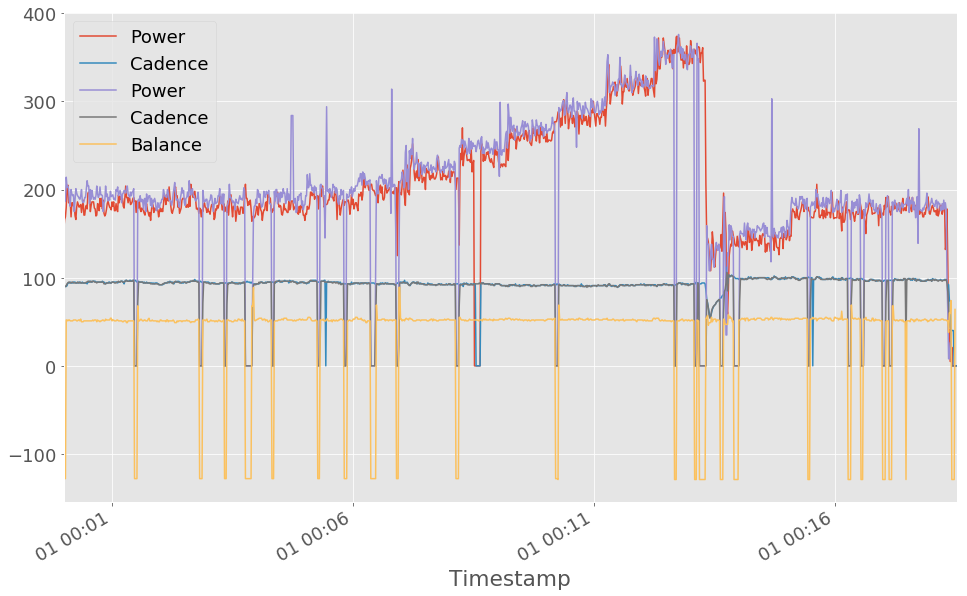

In [8]:
fig, axes = plt.subplots(1, figsize=(16, 10))
ax1 = stages_records.plot(ax=axes)
vector_records.plot(ax=ax1)

## Clean up data and adjust the vector power for the balance
### The Stages are reporting left leg only, therefore I'm using Vector's balance data to calculate the power if it was reported from the left pedal only

In [9]:
def index_3rolling_std(s):
    '''Use rolling 3sigma deviation over 10 sec as an outlier threshold'''
    diff = s - s.rolling(10).mean()
    std = np.std(diff)
    return np.abs(diff) < 3*std 

In [10]:
## Remove low cadence
stages_records = stages_records[stages_records['Cadence'] > 60.0]
vector_records = vector_records[vector_records['Cadence'] > 60.0]
## For vector leave only balance in the range 45..55
vector_records = vector_records[(vector_records['Balance'] > 45.0) & (vector_records['Balance'] < 55.0)]
## Remove very low power readings
stages_records = stages_records[stages_records['Power'] > 50.0]
vector_records = vector_records[vector_records['Power'] > 50.0]
## Remove power outliers using rolling window filtering: 3*sigma criteria
stages_records = stages_records[index_3rolling_std(stages_records['Power'])]
vector_records = vector_records[index_3rolling_std(vector_records['Power'])]
## Remove cadence outliers using rolling window filtering: 3*sigma criteria
stages_records = stages_records[index_3rolling_std(stages_records['Cadence'])]
vector_records = vector_records[index_3rolling_std(vector_records['Cadence'])]
## Recalculate vector power as if it was 2xLeftLeg
vector_records['Power'] = vector_records['Power']*2*(100.0-vector_records['Balance'])/100.0
vector_records = vector_records.drop('Balance', axis=1)

## Plot cleaned data 

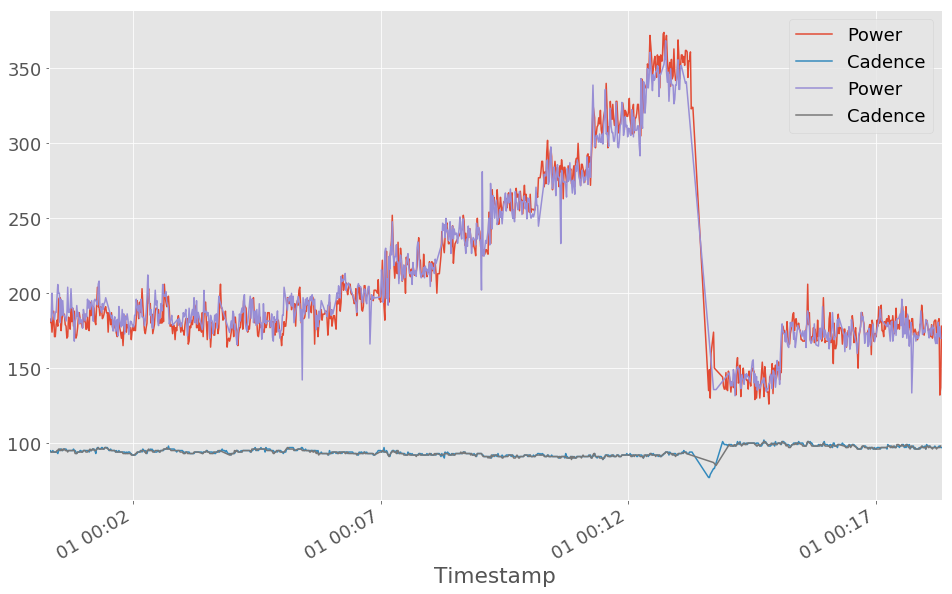

In [11]:
fig, axes = plt.subplots(1, figsize=(16, 10))
ax1 = stages_records.plot(ax=axes)
vector_records.plot(ax=ax1)

## Merge data on timestamps, rename columns to assist plotting and verify cross-correlation
It is expected that the power readings must be well correlated

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1117b4a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111c15898>]], dtype=object)

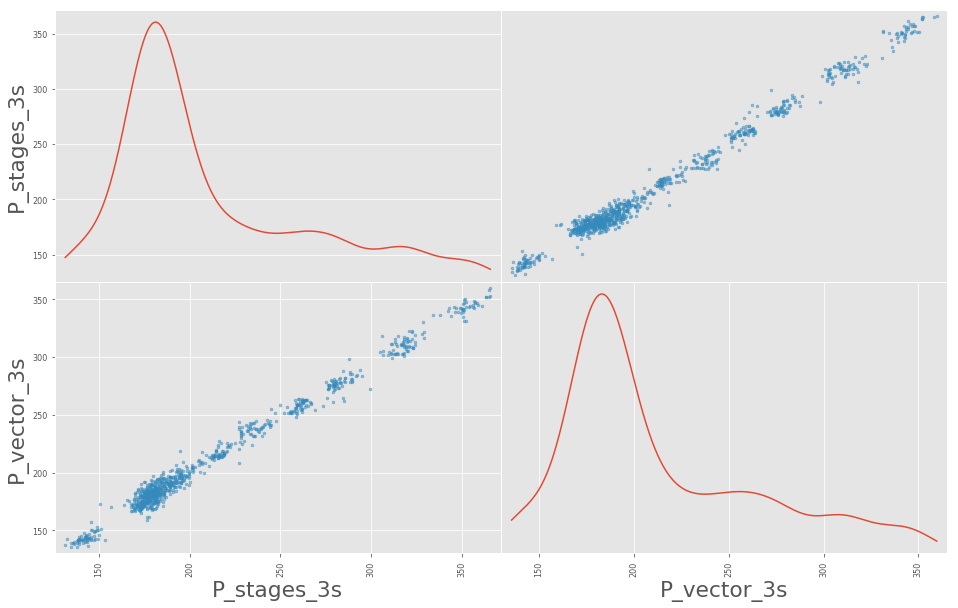

In [12]:
## Merge data on Timestamps
df = pd.merge(stages_records, vector_records, on='Timestamp')
df = df.set_index('Timestamp', drop=False)
## Rename columns
df = df.rename(columns={'Power_x':'P_stages',
                   'Power_y':'P_vector',
                    'Cadence_x': 'Cadence_stages',
                  'Cadence_y':'Cadence_vector'})

df['P_diff'] = df['P_stages'] - df['P_vector']
df['P_stages_3s'] = df['P_stages'].rolling(3).mean()
df['P_vector_3s'] = df['P_vector'].rolling(3).mean()
df['P_diff_3s'] = df['P_stages_3s'] - df['P_vector_3s']
## Plot correlation matrix
pd.scatter_matrix(df[['P_stages_3s', 'P_vector_3s']], diagonal='kde', figsize=(16, 10))

## Publish plots

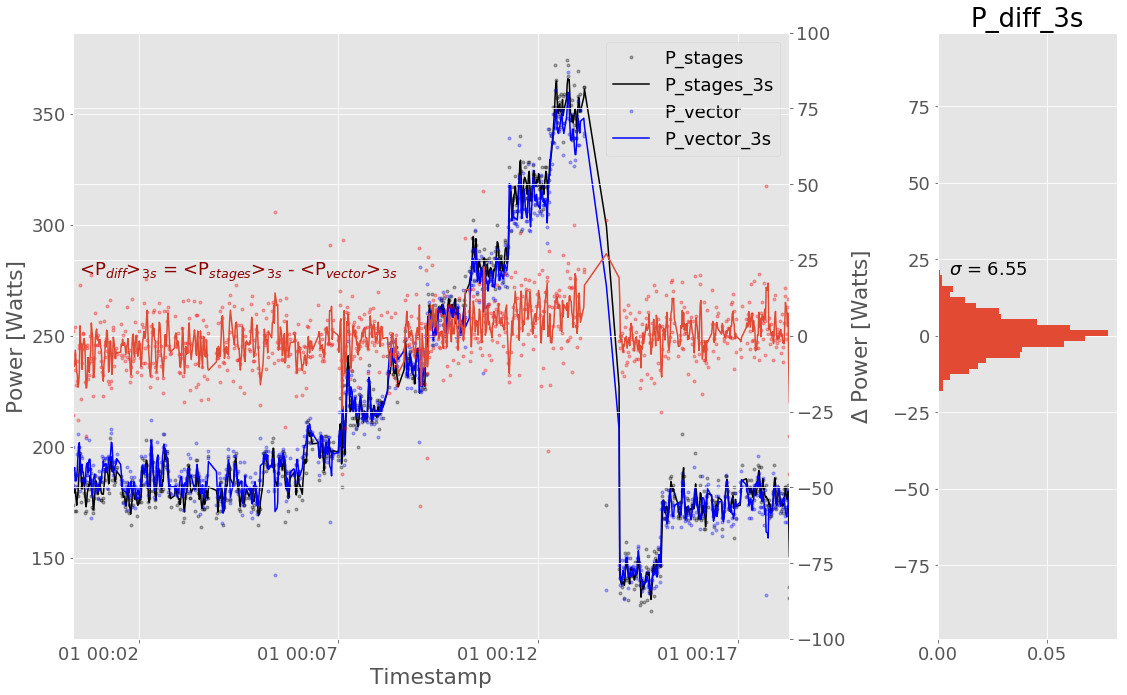

In [14]:
import datetime as dt
import matplotlib.dates as mdates
transparency=0.30

## Generate figure axes list for subplots
fig, axes = plt.subplots(1,2, gridspec_kw = {'width_ratios':[4, 1]}, figsize=(16, 10))

## Plot all power data

# difference
ax2 = df.plot(x=['Timestamp'], y=['P_diff'], ax=axes[0], style=".", c='r', alpha=transparency, secondary_y=True)
df.plot(x=['Timestamp'], y=['P_diff_3s'], kind='line', ax=axes[0], secondary_y=True)
ax2.set_ylim(-100.0, 100.0)
ax2.set_ylabel(r'$\Delta$ Power [Watts]')
font = {'color':'darkred'}
ax2.text(mdates.date2num(dt.datetime(1970, 1,1,0,0,30)), 20,
         r'<P$_{diff}$>$_{3s}$ = <P$_{stages}$>$_{3s}$ - <P$_{vector}$>$_{3s}$',
         fontdict=font,
        clip_on=True)

# stages
df.plot(y=['P_stages'], subplots=True, ax=axes[0], style='.', color='k', alpha=transparency)
df.plot(y=['P_stages_3s'], subplots=True, ax=axes[0], color='k')

# vector
df.plot(y=['P_vector'], subplots=True, ax=axes[0], style='.', color='b', alpha=transparency)
df.plot(y=['P_vector_3s'], subplots=True, ax=axes[0], color='b')

# Add labels
axes[0].set_ylabel('Power [Watts]')


## Add histogram
df[['P_diff_3s']].hist(ax=axes[1], orientation='horizontal', bins=100, range=[-90.0, 90.0], normed=True)
axes[1].text(0.005, 20, r'$\sigma$ = 6.55')

fig.tight_layout()
# fig.savefig('garmin_vs_stages.png')